In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!nvidia-smi

In [ ]:
%cd '/content/drive/MyDrive/GraphsV3'

/content/drive/MyDrive/GraphsV3


In [ ]:
#!pip install imagehash

In [ ]:
import os
import cv2
import sys
import time
import math
import random
import warnings
import imagehash
import statistics
import numpy as np
import networkx as nx
from PIL import Image,ImageColor
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
np.errstate(divide='ignore', invalid='ignore')

In [ ]:
net = cv2.dnn.readNet("yolov4.weights", "yolov4.cfg")

model = ResNet50(weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
path = os.path.join(os.getcwd(),"Images")

In [ ]:
def diff_frames(previous_frame,image):
    diff_thres = 8
    if previous_frame is None:
        return True
    else:
        diff = cv2.absdiff(previous_frame, image)

        diff=np.sum(diff)/previous_frame.shape[0]/previous_frame.shape[1]/3
        #print(diff)
        if abs(diff)>diff_thres:
            return True
        else:
            return False
        #return diff

In [ ]:
vidcap = cv2.VideoCapture('Test.mp4')
success,ima = vidcap.read()
count = 1
name=1
while success:
    #if count%2==0:
    cv2.imwrite(os.path.join(path,"frame%d.jpg" % name), ima) 
    name+=1
    success,ima = vidcap.read()
    count += 1
print(name)

485


In [ ]:
#name=442

In [ ]:
label = dict()
featureL = dict()
labelIndex = 1

In [ ]:
def calculate_hashFunctions(Images):
    hashF = []
    
    for i in range(len(Images)):
        hashF.append(imagehash.phash(Image.fromarray(Images[i]).convert('RGB')))
        
    return hashF

In [ ]:
def Find_Nearest_Label(value):
    global label
    global labelIndex
    global featureL
    minVal = float('inf')
    minIdx = None
    
    for val,index in label.items():
        temp = abs(value-val)
        if temp<minVal:
            minVal=temp
            minIdx=val
    
    threshold = 25
    
    if minVal <= threshold:
        return label[minIdx]
    else:
        label[value] = labelIndex
        labelIndex+=1
        return label[value]

In [ ]:
def Find_Label(hash_val,Images):
    global label
    global labelIndex
    global featureL
    Labels=[]
    
    if len(label)==0:
        for i in range(len(hash_val)):
            label[hash_val[i]] = labelIndex
            Labels.append(labelIndex)
            featureL[labelIndex] = Images[i]
            labelIndex+=1
    else:
        for i in range(len(hash_val)):
            temp = Find_Nearest_Label(hash_val[i])
            Labels.append(temp)
            featureL[temp] = Images[i]
    return Labels    

In [ ]:
def create_graph(Features,time,Images):
    alpha=0.1
    beta=0.9
    L = []
    G = nx.Graph()

    hashF = calculate_hashFunctions(Images)
    Labels = Find_Label(hashF,Images)
    #print(Labels)
    
    for i in range(0,len(Features)):
        for j in range(i+1,len(Features)):
            dissimilarity = abs(hashF[i]-hashF[j])
            distance = np.linalg.norm(Features[i] - Features[j])
            weight = alpha*dissimilarity + beta*distance
            L.append(weight)
            #G.add_edge(str(Labels[i]),str(Labels[j]),weight=weight,time=time)
        
    
    similarity_array = np.array(L)
    similarity_array = preprocessing.normalize([similarity_array])
    similarity_array = similarity_array.flatten()
    similarity_array = 1 - similarity_array
    similarity_array = similarity_array.tolist()
    
    std = statistics.stdev(similarity_array)
    mean = statistics.mean(similarity_array)
    outlierL = mean-3*std
    outlierH = mean+3*std
    
    idx=0
    for i in range(0,len(Features)):
        for j in range(i+1,len(Features)):
            if str(Labels[i])!=str(Labels[j]):
                G.add_edge(str(Labels[i]),str(Labels[j]),weight=similarity_array[idx],time=time)
            idx+=1
            
    
    for i in range(0,len(Features)):
        for j in range(i+1,len(Features)):
            if G.has_edge(str(Labels[i]),str(Labels[j])):
                edge_value = G.edges()[str(Labels[i]),str(Labels[j])]['weight']
                if  edge_value < outlierL or edge_value > outlierH:
                    try:
                        G.remove_edge(str(Labels[i]),str(Labels[j]))
                    except:
                        continue
    return (G,Labels)

In [ ]:
features = []
images = []
classes = []
#final_index = dict()
#final_boxes = dict()
#final_labels = dict()
graph_labels=dict()


with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

colors = np.random.uniform(0, 255, size=(len(classes), 3))

Graphs = []
c=1
t=1
previous_frame = None
curr_frame = cv2.imread('Images/frame1.jpg')

while c<name:
    if diff_frames(previous_frame,curr_frame):
        #print(c)
        #print(str(c) + " " + str(alpit))

        frame = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2RGB)

        height, width, channels = frame.shape

        blob = cv2.dnn.blobFromImage(frame, 1/255, (416, 416), (0, 0, 0), swapRB=True, crop=False)
        net.setInput(blob)
        outputs = net.forward(net.getUnconnectedOutLayersNames())

        boxes = []
        confidences = []
        class_ids = []

        for output in outputs:
            for detection in output:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]

                if confidence > 0.5:
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)

                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)

                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)

        indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

        #print(len(indices))

        pick=0
        if len(indices)<=7: 
            #print("hi")
            c+=1
            #previous_frame=curr_frame.copy()
            curr_frame = cv2.imread('Images/frame{}.jpg'.format(c))
            continue

        #final_index[t] = indices
        #final_boxes[t] = boxes
        for i in indices:
            box = boxes[i]
            x = box[0]
            y = box[1]
            w = box[2]
            h = box[3]

            color = colors[class_ids[i]]
            cv2.rectangle(curr_frame, (x, y), (x + w, y + h), color, 2)

            roi = frame[y:y + h, x:x + w]
            if 0 in roi.shape: 
                pick=1
                break
            roi = cv2.resize(roi, (224, 224))
            images.append(roi)
            img = image.img_to_array(roi)
            img = np.expand_dims(img, axis=0)
            img = preprocess_input(img)

            feature = model.predict(img,verbose=0)
            feature = feature.flatten()
            features.append(feature)

        if pick == 1: 
            features = [] 
            images=[] 
            #previous_frame=curr_frame.copy()
            c+=1
            curr_frame = cv2.imread('Images/frame{}.jpg'.format(c))
            continue

        G,tempL = create_graph(features,t,images)
        #final_labels[t] = tempL
        
        if len(features)!=len(G.nodes()):
            features=[]
            images=[]
            c+=1
            curr_frame = cv2.imread('Images/frame{}.jpg'.format(c))
            continue
            
        graph_labels[t] = [boxes,indices,tempL,c]
        #holdon.append([len(features),len(G.nodes())])
        
            
        features = []
        images=[]

        Graphs.append(G)
        t+=1
        previous_frame=curr_frame
        print(c)
    c+=1
    curr_frame = cv2.imread('Images/frame{}.jpg'.format(c))
 
    #if cv2.waitKey(1) & 0xFF == ord('q'):
    #    break

#cap.release()
#cv2.destroyAllWindows()

1
8
14
52
62
84
122
145
152
187
205
216
223
224
227
228
230
231
236
242
261
272
274
426
436
440


In [ ]:
len(label)

40

In [ ]:
len(featureL)

40

In [ ]:
len(Graphs)

26

In [ ]:
attrs = {}

for i in range(1,len(label)+1):
    attrs[str(i)] = {"id":i}

In [ ]:
for g in Graphs:
    nx.set_node_attributes(g,attrs)

In [ ]:
def Model(n,t):
    vertices = list(map(str,list(range(1,n+1))))
    g = nx.Graph()
    for node_1 in vertices:
        for node_2 in vertices[int(node_1):]:
            g.add_edge(node_1,node_2,probability=random.random())

    Subgraph = dict()
    Subgraph['timedepth'] = t
    Subgraph['graph'] = g
    
    attrs = dict()
    
    for i in range(len(vertices)):
        attrs[str(i+1)] = {'id':i+1}
        
    
    nx.set_node_attributes(Subgraph['graph'],attrs)
    #nx.draw_networkx(g,node_color='k')
    #plt.axis('equal')
    #plt.show()
    
    return Subgraph

In [ ]:
#Subgraph_Model = Model(5,3)
Nc = 10
PTeleport = 0.1
epsilon = sys.float_info.epsilon
gamma = 1000
alpha = 0.5

In [ ]:
def LinearizedVertexOrder(G):
    return sorted(G.nodes(), key = lambda x : G.nodes[x]['id'])

In [ ]:
def getEdgeWalkComponent(n,d,GT):
    Graph_limit = len(GT)-d
    Uniform_graph_index = random.randint(0,Graph_limit-1)
    #print(Uniform_graph_index)
    g = GT[Uniform_graph_index]
    
    C = dict()
    
    visited = set()
    EdgesList = list()
    exit=1
    
    while True:
        a,b = random.choice(list(g.edges()))
        t = g.get_edge_data(a,b)['time']
        check=0
        for i in range(t-1,t+d-1):
            if GT[i].has_node(a)==False or GT[i].has_node(b)==False:
                check=1
                break
        if check==0:
            C['time'] = g.get_edge_data(a,b)['time']
            C['d'] = d
            visited.add(a)
            visited.add(b)
            EdgesList.append((a,b))
            break
   #print(visited)

    start_time = time.time()

    while len(visited) < n:
        randomNode = random.choice(list(visited))
        randomNode1,randomNode2 = random.choice(list(nx.edges(g,randomNode)))
        #print(randomNode + " " + randomNode1 + " " + randomNode2)
        if randomNode2 not in visited:
            t = C['time']
            check=0
            for i in range(t-1,t+d-1):
                if GT[i].has_node(randomNode2)==False:
                    check=1
                    break
            if check==0:
                visited.add(randomNode2)
                EdgesList.append((randomNode1,randomNode2))
        end_time=time.time()
        
        if abs(end_time-start_time) >= 1:
            return None
        
    
    #print(visited, end=" ")
    #print(C['time'])
    #print("Done")
    Component = g.subgraph(visited)
    Component = Component.copy()
    C['graph'] = Component
    C['Dgraph'] = g
    
    return C

In [ ]:
def FindProbability(SubgraphM,Component,GT):
    d = SubgraphM['timedepth']
    t = Component['time']
    #print("time",t)
    #print("d",d)
    orderM = LinearizedVertexOrder(SubgraphM['graph'])
    finalPC = 1
    for i in range(t-1,t+d-1):
        if i>=len(GT):
            break
        else:
            g = GT[i]
            Component_Snapshot = g.subgraph(list(Component['graph'].nodes()))
            #print(Component['graph'].nodes(), end= " ")
            #print(len(list(Component['graph'].nodes())),end= " ")
            #print(i+1)
            Component_Snapshot = Component_Snapshot.copy()
            orderS = LinearizedVertexOrder(Component_Snapshot)
            PC = Probability(SubgraphM,Component_Snapshot,orderM,orderS)
            finalPC = finalPC * PC
    return finalPC            

In [ ]:
def Probability(SubgraphM,Component_Snapshot,orderM,orderS):
    n = len(orderM)
    Prob = 1
    #print("n:",n,end=" ")
    #print("C:",len(orderS),end=" ")
    #print("M",len(orderM))
    for i in range(0,n):
        for j in range(i+1,n):
            #print(i,j)
            ModelV_1,ModelV_2 = orderM[i],orderM[j]
            SnapshotV_1,SnapshotV_2 = orderS[i],orderS[j]
            #print(ModelV_1,ModelV_2)
            #print(SnapshotV_1,SnapshotV_2)
            if Component_Snapshot.has_edge(SnapshotV_1,SnapshotV_2):
                Prob = Prob * SubgraphM['graph'].edges()[str(i+1),str(j+1)]['probability']
            else:
                Prob = Prob * (1 - SubgraphM['graph'].edges()[str(i+1),str(j+1)]['probability'])
    #print(Prob)
    return Prob
                

In [ ]:
def checkConnected(Component,t,SubgraphM,GT):
    d = SubgraphM['timedepth']
    g = Component['graph']
    L = list(g.nodes())
    
    for i in range(t-1,t+d-1):
        if i>=len(GT):
            break
        else:
            for j in L:
                if GT[i].has_node(j)==False:
                    return False
            #if nx.is_connected(GT[i].subgraph(list(g.nodes())))!=True:
             #   return False
    return True 

In [ ]:
def GENERALIZEDE(SubgraphM,GT):
    
    C=None
    Pc=0
    while C==None or Pc==0:
        C = getEdgeWalkComponent(len(SubgraphM['graph'].nodes()),SubgraphM['timedepth'],GT)
        if C!=None:
            Pc = FindProbability(SubgraphM,C,GT)
    
    L = list()
    
    #while Pc==0:
    #    C = getEdgeWalkComponent(len(SubgraphM['graph'].nodes()),SubgraphM['timedepth'],GT)
    #    Pc = FindProbability(SubgraphM,C,GT)
        
    L.append([C,Pc])
    #print(Pc)
    while len(L) < 5:
        Cprev = C
        Pprev = Pc
        r = random.random()
        timePoint=0
        
        if r>= PTeleport:
            To = random.choice([C['time'],C['time']+1,C['time']-1])
            #print(To)
            if To<=0 or To>len(GT)-SubgraphM['timedepth']:
                timePoint=1
                continue
            
            if checkConnected(C,To,SubgraphM,GT) == True:
                C['time'] = To
                g = GT[To-1].copy()
                Component = g.subgraph(list(C['graph'].nodes()))
                Component = Component.copy()
                C['graph'] = Component
                C['Dgraph'] = g.copy()
            
            
        else:
            C = getEdgeWalkComponent(len(SubgraphM['graph'].nodes()),SubgraphM['timedepth'],GT)
            #print(C['graph'].nodes())
            
        if C==None:
            C=Cprev
            Pc=Pprev
            continue
            
        if timePoint == 1:
            C = Cprev
            Pc = Pprev
            continue
            
        if len(SubgraphM['graph'].nodes()) != len(C['graph'].nodes()):
            C = Cprev
            Pc = Pprev
            #print("a")
            continue
          
        #print(C['graph'].nodes())
        Pc = FindProbability(SubgraphM,C,GT)
        #print("2 Completed")
        #print(len(SubgraphM['graph'].nodes()))
        #print(len(C['graph'].nodes()))

        #if Pprev==0:
        #    print(Pprev)
        #    C = Cprev.copy()
        #    Pc = Pprev
        #    continue
            
        Alpha = min(1,Pc/Pprev)
        
        diff = 1-Alpha
        
        if diff > 0:
            C = Cprev
            Pc = Pprev
            continue
        
        check=0
        for component in L:
            if C['graph'] == component[0]['graph']:
                check=1
        
        if check==1:
            C = Cprev
            Pc = Pprev
            continue
        
        if len(SubgraphM['graph'].nodes()) != len(C['graph'].nodes()):
            C = Cprev
            Pc = Pprev
            continue
        
        L.append([C,Pc])
        print(len(L),end=" ")
        
    return L

In [ ]:
def checkConvergence(SubgraphM_1,SubgraphM_2):
    
    if SubgraphM_2==None:
        return False
    
    converge = True
    
    t1 = SubgraphM_1['timedepth']
    t2 = SubgraphM_2['timedepth']
    
    converge = math.isclose(t1,t2)
    
    if converge==False:
        return False
    
    n1 = len(SubgraphM_1['graph'].nodes())
    n2 = len(SubgraphM_2['graph'].nodes())
    
    converge = math.isclose(n1,n2)
    if converge==False:
        return False
    
    order_1 = LinearizedVertexOrder(SubgraphM_1['graph'])
    order_2 = LinearizedVertexOrder(SubgraphM_2['graph'])
    
    sumP=0
    
    for i in range(len(order_1)):
        for j in range(i+1,len(order_1)):
            if random.random() > 0.3:
                probability_1 = SubgraphM_1['graph'].edges[str(i+1),str(j+1)]['probability']
                probability_2 = SubgraphM_2['graph'].edges[str(i+1),str(j+1)]['probability']
                sumP+=abs(probability_1-probability_2)
    #print(sumP)
    sumP/=(len(order_1)*len(order_1))
    #print("Convergence: ", sumP)
    
    if sumP<=0.0005:
        return True
    else:
        return False

In [ ]:
def gradientAscentTimeDepth(L,N,d,GT):
    
    h=1
    while True:
        MH_next = getModel(L,N,d+h,GT)
        MH_prev = getModel(L,N,d-h,GT)
        
        utility_gradient =abs( Utility(MH_next) - Utility(MH_prev))
        #print(utility_gradient)

        if utility_gradient <= 0.001:
            break
        
        d = d + ((gamma*abs(utility_gradient))/(2*h))
        #print("d",d)
        
        d = int(round(d))
    return d
        

In [ ]:
def find_existence(CV_1,CV_2,t,d,GT):
    
    count = 0
    for i in range(t-1,t+d-1):
        if i>=len(GT):
            break
        if GT[i].has_edge(CV_1,CV_2):
            count+=1
    return count        

In [ ]:
def getModel(L,N,d,GT):
    
    M = Model(N,d)
    
    OrderM = LinearizedVertexOrder(M['graph'])
    
    #print("n",n)
    for i in range(0,N):
        for j in range(i+1,N):
            ModelV_1,ModelV_2 = OrderM[i],OrderM[j]
            Nj_value=0
            for k in range(0,len(L)):
                OrderC = LinearizedVertexOrder(L[k][0]['graph'])
                #print(OrderC,i,j)
                ComponentV_1,ComponentV_2 = OrderC[i],OrderC[j]
                count = find_existence(ComponentV_1,ComponentV_2,L[k][0]['time'],L[k][0]['d'],GT)
                Nj_value+= count*L[k][1]
            Pj_value = math.sqrt(abs(Nj_value/d))
            M['graph'][ModelV_1][ModelV_2]['probability'] = Pj_value
        
    M = Normalize(M)
    #print("Model" , M['graph']['1'])
    return M

In [ ]:
def Utility(M):
    value = 1
    nodes = list(M['graph'].nodes())
    d = M['timedepth']
    for i in range(0,len(nodes)):
        for j in range(i+1,len(nodes)):
            ModelV_1,ModelV_2 = nodes[i],nodes[j]
            Pj = M['graph'][ModelV_1][ModelV_2]['probability']
            value*=np.exp(d*(Pj-0.3))
    return value

In [ ]:
def GeneralizedM(L,SubgraphM,GT):
    
    M_next = SubgraphM
    M_prev = None
    L_prev = L
    n_prev  = len(SubgraphM['graph'].nodes())
    d_prev = SubgraphM['timedepth']
    #i=0
    while (not checkConvergence(M_next,M_prev)):
        #print(M_next)
        #print(M_prev)
        #print(i)
        #i+=1
        L_temp = L_prev.copy()
        d = d_prev
        n = random.choice([n_prev,n_prev-1,n_prev+1])
        
        if n == len(L_temp[0][0]['Dgraph'].nodes()):
            continue
        if n<=5 or n>=9:
            continue
        
        #print(n)
        #check=0
        for component in L_temp:
            if n > n_prev:
                Component_nodes = list(component[0]['graph'].nodes())
                graph_nodes = list(component[0]['Dgraph'].nodes())
                new_nodes = [node for node in graph_nodes if node not in Component_nodes]
                #if len(new_nodes)==0:
                    #check=1
                    #break
                #print("G:",len(graph_nodes))
                #print("C:",len(Component_nodes))
                #print("R:",len(removal_nodes))

       
                assign=False
                
                while assign!=True:
                    new_node = random.choice(new_nodes)
                    attribute_id = component[0]['Dgraph'].nodes()[new_node]['id']
                    for node in Component_nodes:
                        if component[0]['Dgraph'].has_edge(node,new_node) == True:
                            component[0]['graph'].add_edge(node,new_node)
                            component[0]['graph'].nodes[new_node]['id'] = attribute_id
                            Component = component[0]['Dgraph'].subgraph(component[0]['graph'].nodes())
                            Component = Component.copy()
                            component[0]['graph'] = Component
                            assign=True
                            break
                #print("G:",len(graph_nodes))
                #print("C:",len(Component_nodes))
                
            elif n < n_prev:
                Articulation_points = list(nx.articulation_points(component[0]['graph']))
                nodes = list(component[0]['graph'].nodes())
                removal_nodes = [node for node in nodes if node not in Articulation_points]
                vertex = random.choice(removal_nodes)
                component[0]['graph'].remove_node(vertex)
            #print(Subgraph_Model['graph'].nodes())
            #print(component[0]['graph'].nodes())
            
        #if check==1:
         #   continue
        #for component in L_temp:
         #   print(len(component[0]['graph'].nodes()))
        #print(n)
        d = gradientAscentTimeDepth(L_temp,n,d,GT)
        M = getModel(L_temp,n,d,GT)
        #M = Normalize(M)
        #M = Preprocess_Model(M)
        
        if M_prev==None or (Utility(M)*(1e+10)) >= Utility(M_next):
            M_prev = M_next
            M_next = M
            
        #print("M : " , Utility(M))
        #print("M_next : ",Utility(M_next))
        Alpha = min(1,Utility(M)/Utility(M_next))
        
        #diff = 1-Alpha
        
        if Alpha==1 :
            L_prev = L_temp
            n_prev = len(L_prev[0][0]['graph'].nodes())
            d_prev = d
        else:
            if M_prev==None:
                L_prev = L
                n_prev  = len(L[0][0]['graph'].nodes())
                d_prev = SubgraphM['timedepth']
            else:
                n_prev = len(L_prev[0][0]['graph'].nodes())
                d_prev = M_prev['timedepth']
        
    return M_next  

In [ ]:
def NormalizeData(data):
    data = (1 + (data - np.min(data))) / (1 + (np.max(data) - np.min(data)) + len(data))
    return data.tolist()

In [ ]:
def Normalize(SubgraphM):
    L = []
    n = len(SubgraphM['graph'].nodes())
    for i in range(n):
        for j in range(i+1,n):
            L.append(SubgraphM['graph'][str(i+1)][str(j+1)]['probability'])
    norm = NormalizeData(L)
    
    #print(norm)
    x=0
    for i in range(n):
        for j in range(i+1,n):
            SubgraphM['graph'][str(i+1)][str(j+1)]['probability'] = norm[x]
            x+=1
    
    return SubgraphM

In [ ]:
def Preprocess_Model(SubgraphM):
    #L=[]
    n = len(SubgraphM['graph'].nodes())
    for i in range(n):
        for j in range(i+1,n):
            if SubgraphM['graph'][str(i+1)][str(j+1)]['probability'] == 0:
                SubgraphM['graph'][str(i+1)][str(j+1)]['probability'] = 0.01
    #print(out)
    return SubgraphM


In [ ]:
def NormalizeP(L):
    store=[]
    for i in range(len(L)):
        store.append(L[i][1])
    store = NormalizeData(store)
    #print(store)
    for i in range(len(L)):
        L[i][1] = store[i]
    return L

In [ ]:
Subgraph_Model = Model(6,3)
for i in range(10):
    print("Iteration : " + str(i+1))
    L = GENERALIZEDE(Subgraph_Model,Graphs)
    L = NormalizeP(L)
    print("2 3 4 5 Expectation Completed")
    Subgraph_Model = GeneralizedM(L,Subgraph_Model,Graphs)
    print("Maximization Completed")
    #Subgraph_Model = Normalize(Subgraph_Model)
    #Subgraph_Model = Preprocess_Model(Subgraph_Model)
    #print(Subgraph_Model['timedepth'])
    #Subgraph_Model['timedepth'] = int(Subgraph_Model['timedepth'])
    #print(Subgraph_Model['timedepth'])

Iteration : 1
2 3 4 5 Expectation Completed
Maximization Completed
Iteration : 2
2 3 4 5 Expectation Completed
Maximization Completed
Iteration : 3
2 3 4 5 Expectation Completed
Maximization Completed
Iteration : 4
2 3 4 5 Expectation Completed
Maximization Completed
Iteration : 5
2 3 4 5 Expectation Completed
Maximization Completed
Iteration : 6
2 3 4 5 Expectation Completed
Maximization Completed
Iteration : 7
2 3 4 5 Expectation Completed
Maximization Completed
Iteration : 8
2 3 4 5 Expectation Completed
Maximization Completed
Iteration : 9
2 3 4 5 Expectation Completed
Maximization Completed
Iteration : 10
2 3 4 5 Expectation Completed
Maximization Completed


In [ ]:
# for i in Graphs:
#   print(i.nodes())
#   #print(i['graph'].nodes())

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']
['2', '1', '3', '5', '4', '8', '6', '9', '7', '11', '10', '12', '14']
['1', '8', '4', '3', '22', '6', '7', '9', '21', '10', '13', '15']
['22', '17', '8', '3', '1', '24', '6', '7', '11', '21', '14', '10', '23', '20', '13']
['28', '8', '27', '5', '4', '6', '1', '3', '7', '9', '12', '10', '17', '25']
['8', '28', '4', '6', '3', '5', '16', '30', '29', '7', '19', '9', '10', '12']
['32', '35', '6', '3', '5', '8', '4', '12', '10', '7', '20', '31', '13']
['15', '6', '1', '32', '3', '5', '10', '4', '35', '20', '36', '11', '13']
['6', '8', '10', '5', '1', '28', '3', '4', '20', '31', '13', '33']
['36', '6', '30', '32', '5', '3', '10', '4', '7', '16', '11', '33', '31', '20']
['6', '19', '1', '3', '10', '5', '4', '7', '18', '31', '20']
['6', '15', '17', '3', '4', '10', '5', '8', '24', '20', '13', '7']
['8', '1', '5', '17', '3', '10', '4', '37', '36', '13', '24']
['8', '32', '4', '5', '6', '9', '23', '7', '37', '3', '10']
['8', '32

In [ ]:
#L[4][0]['graph'].remove_node('19')

In [ ]:
predict_nodes = L[0][0]['graph'].nodes()
predict_time = L[0][0]['time']

import matplotlib.pyplot as plt
import random

number_of_colors = len(predict_nodes)

colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

label_colors = dict()

for i,node in enumerate(predict_nodes):
    label_colors[node] = colors[i]
    
#print(label_colors)

for idx,val in label_colors.items():
    label_colors[idx] = ImageColor.getcolor(label_colors[idx],'RGB')
    
print(label_colors)

{'6': (158, 246, 204), '3': (135, 80, 57), '5': (157, 179, 47), '10': (156, 112, 237), '4': (121, 234, 37), '20': (134, 45, 62)}


In [ ]:
c=1
alpha = 0.4

for tm in range(predict_time,predict_time+Subgraph_Model['timedepth']):
    image = cv2.imread("Images/frame{}.jpg".format(graph_labels[tm][3]))
    overlay = image.copy()
    for node in predict_nodes:
        
        index_node = graph_labels[tm][2].index(int(node))
        box_num = graph_labels[tm][1][index_node]
        box = graph_labels[tm][0][box_num]
        x = box[0]
        y = box[1]
        w = box[2]
        h = box[3]    
        
        cv2.rectangle(overlay, (x, y), (x + w, y + h), label_colors[node], -1)
        image_new = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)
        #cv2.imshow("some", image_new)
    cv2.imwrite("Prediction/Image%d.jpg"%c,image_new)
    c+=1


In [ ]:
L

[[{'time': 8,
   'd': 3,
   'graph': <networkx.classes.graph.Graph at 0x7f0c28322260>,
   'Dgraph': <networkx.classes.graph.Graph at 0x7f0c24ccddb0>},
  0.16666666666666666],
 [{'time': 8,
   'd': 3,
   'graph': <networkx.classes.graph.Graph at 0x7f0c28320a00>,
   'Dgraph': <networkx.classes.graph.Graph at 0x7f0c25da8e20>},
  0.16666666666666666],
 [{'time': 7,
   'd': 3,
   'graph': <networkx.classes.graph.Graph at 0x7f0c28322080>,
   'Dgraph': <networkx.classes.graph.Graph at 0x7f0c28322fe0>},
  0.16666666666666666],
 [{'time': 7,
   'd': 3,
   'graph': <networkx.classes.graph.Graph at 0x7f0c28320af0>,
   'Dgraph': <networkx.classes.graph.Graph at 0x7f0c28321ff0>},
  0.16666666666666666],
 [{'time': 4,
   'd': 3,
   'graph': <networkx.classes.graph.Graph at 0x7f0c28321ed0>,
   'Dgraph': <networkx.classes.graph.Graph at 0x7f0c28859d80>},
  0.16666666666666666]]

In [ ]:
res=0
f_t=None
for i in L:
  cal_val = abs(graph_labels[i[0]['time']+i[0]['d']-1][3]-graph_labels[i[0]['time']][3])
  if cal_val>res:
    res=cal_val
    f_t = i[0]['time']

print(res)
print(f_t)

42
8


In [ ]:
import warnings,logging
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [ ]:
#!pip install transformers

In [ ]:
from transformers import pipeline
from transformers import BlipProcessor, BlipForConditionalGeneration

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")
gpt_image_to_text = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")

# [{'generated_text': 'a soccer game with a player jumping to catch the ball '}]


In [ ]:
gpt_image_to_text("Images/frame100.jpg")

[{'generated_text': 'a crowded restaurant with people eating and drinking '}]

In [ ]:
from PIL import Image
inputs = processor(Image.open("Images/frame100.jpg").convert('RGB'), return_tensors="pt")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

people are sitting at tables in a restaurant with many tables


In [ ]:
tm_final = graph_labels[L[0][0]['time']][3]
original_img = Image.open(r"Images/frame{}.jpg".format(tm_final)).convert('RGB')
img_arr = np.array(original_img)

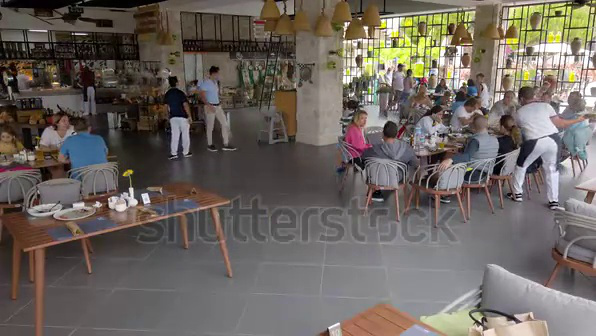

In [ ]:
original_img.show()

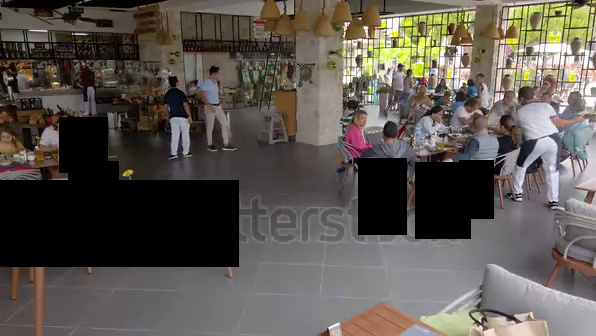

In [ ]:
for node in predict_nodes:
  index_node = graph_labels[L[0][0]['time']][2].index(int(node))
  box_num = graph_labels[L[0][0]['time']][1][index_node]
  box = graph_labels[L[0][0]['time']][0][box_num]
  x = box[0]
  y = box[1]
  w = box[2]
  h = box[3]  
  #print(x,y,w,h)  
  img_arr[y:y+h,x:x+w] = (0,0,0)

img = Image.fromarray(img_arr)

img.show()

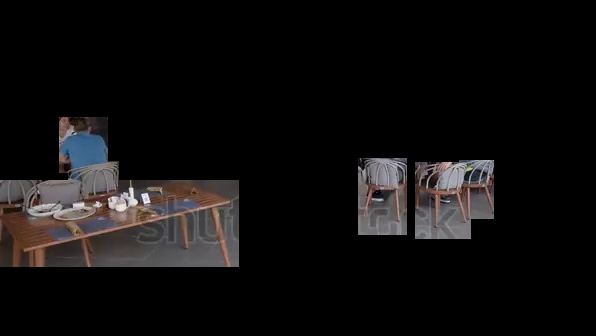

In [ ]:
final_img_arr = cv2.bitwise_xor(np.array(img),np.array(original_img))

final_img = Image.fromarray(final_img_arr)

final_img.show()

In [ ]:
gpt_captions_normal = []

In [ ]:
start_time = time.time()
for i in range(len(os.listdir('Images'))):
  gpt_captions_normal.append(gpt_image_to_text("Images/frame{}.jpg".format(i+1)))
end_time = time.time()

In [ ]:
print(end_time-start_time)

1596.384248495102


In [ ]:
densest_image_list = list()
densest_time_list = list()
captions_normal_densest = []
start = graph_labels[L[0][0]['time']][3]
end = graph_labels[L[0][0]['time']+L[0][0]['d']-1][3]
for i in range(L[0][0]['time'],L[0][0]['time']+L[0][0]['d']):
  densest_image_list.append(graph_labels[i][3])
  densest_time_list.append(i)
print(densest_image_list)
print(densest_time_list)

[145, 152, 187]
[8, 9, 10]


In [ ]:
gpt_start_time_captioning = time.time()

gpt_densest_captions = dict()
gpt_densest_image_list = list()
gpt_densest_time_list = list()

gpt_captions_normal_densest = []
start = graph_labels[L[0][0]['time']][3]
end = graph_labels[L[0][0]['time']+L[0][0]['d']-1][3]
for i in range(L[0][0]['time'],L[0][0]['time']+L[0][0]['d']):
  gpt_densest_image_list.append(graph_labels[i][3])
  gpt_densest_time_list.append(i)
#print(densest_image_list)
#print(densest_time_list)

#nearest_densest_img_original.show()
for i in range(len(gpt_densest_image_list)):
  nearest_densest_img_original = Image.open(r"Images/frame{}.jpg".format(gpt_densest_image_list[i])).convert('RGB')
  nearest_densest_img_arr = np.array(nearest_densest_img_original)
  for node in predict_nodes:
    index_node = graph_labels[gpt_densest_time_list[i]][2].index(int(node))
    box_num = graph_labels[gpt_densest_time_list[i]][1][index_node]
    box = graph_labels[gpt_densest_time_list[i]][0][box_num]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]  
    nearest_densest_img_arr[y:y+h,x:x+w] = (0,0,0)
  final_img_arr = cv2.bitwise_xor(nearest_densest_img_arr,np.array(nearest_densest_img_original))
  final_img = Image.fromarray(final_img_arr)
  nearest_densest_img = Image.fromarray(nearest_densest_img_arr)
  final_cap = gpt_image_to_text(nearest_densest_img)[0]['generated_text']+" "+gpt_image_to_text(final_img)[0]['generated_text']
  gpt_densest_captions[gpt_densest_time_list[i]] = final_cap

#print(densest_captions)

for i in range(len(os.listdir('Images'))):
  if i+1 in range(start,end+1):
    img_index = gpt_densest_image_list[min(range(len(gpt_densest_image_list)), key = lambda i: abs(gpt_densest_image_list[i]-(i+1)))]
    time_den = densest_time_list[gpt_densest_image_list.index(img_index)]
    gpt_captions_normal_densest.append(gpt_densest_captions[time_den])
  else:
    gpt_captions_normal_densest.append(gpt_image_to_text("Images/frame{}.jpg".format(i+1)))
  
gpt_end_time_captioning = time.time()

In [ ]:
print(gpt_end_time_captioning-gpt_start_time_captioning)

1414.9951524734497


In [ ]:
salesforce_captions_normal = []

In [ ]:
salesforce_start_time_normal = time.time()
for i in range(len(os.listdir('Images'))):
  inputs = processor(Image.open("Images/frame{}.jpg".format(i+1)).convert('RGB'), return_tensors="pt")
  out = model.generate(**inputs)
  salesforce_captions_normal.append(processor.decode(out[0], skip_special_tokens=True))
salesforce_end_time_normal = time.time()

In [ ]:
print(salesforce_end_time_normal-salesforce_start_time_normal)

7327.10099029541


In [ ]:
salesforce_start_time_captioning = time.time()

salesforce_densest_captions = dict()
salesforce_densest_image_list = list()
salesforce_densest_time_list = list()

salesforce_captions_normal_densest = []
start = graph_labels[L[0][0]['time']][3]
end = graph_labels[L[0][0]['time']+L[0][0]['d']-1][3]
for i in range(L[0][0]['time'],L[0][0]['time']+L[0][0]['d']):
  salesforce_densest_image_list.append(graph_labels[i][3])
  salesforce_densest_time_list.append(i)
#print(densest_image_list)
#print(densest_time_list)

#nearest_densest_img_original.show()
for i in range(len(salesforce_densest_image_list)):
  nearest_densest_img_original = Image.open(r"Images/frame{}.jpg".format(salesforce_densest_image_list[i])).convert('RGB')
  nearest_densest_img_arr = np.array(nearest_densest_img_original)
  for node in predict_nodes:
    index_node = graph_labels[salesforce_densest_time_list[i]][2].index(int(node))
    box_num = graph_labels[salesforce_densest_time_list[i]][1][index_node]
    box = graph_labels[salesforce_densest_time_list[i]][0][box_num]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]  
    nearest_densest_img_arr[y:y+h,x:x+w] = (0,0,0)
  final_img_arr = cv2.bitwise_xor(nearest_densest_img_arr,np.array(nearest_densest_img_original))
  final_img = Image.fromarray(final_img_arr)
  nearest_densest_img = Image.fromarray(nearest_densest_img_arr)
  final_cap1 = processor(nearest_densest_img,return_tensors='pt')
  final_cap2 = processor(final_img,return_tensors='pt')
  out_1 = model.generate(**final_cap1)
  out_2 = model.generate(**final_cap2)
  out_1 = processor.decode(out_1[0], skip_special_tokens=True)
  out_2 = processor.decode(out_2[0], skip_special_tokens=True)
  final_cap = out_1+" "+out_2
  salesforce_densest_captions[salesforce_densest_time_list[i]] = final_cap

#print(densest_captions)

for i in range(len(os.listdir('Images'))):
  if i+1 in range(start,end+1):
    img_index = salesforce_densest_image_list[min(range(len(salesforce_densest_image_list)), key = lambda i: abs(salesforce_densest_image_list[i]-(i+1)))]
    time_den = salesforce_densest_time_list[salesforce_densest_image_list.index(img_index)]
    salesforce_captions_normal_densest.append(salesforce_densest_captions[time_den])
  else:
    inputs = processor(Image.open("Images/frame{}.jpg".format(i+1)).convert('RGB'),return_tensors="pt")
    out = model.generate(**inputs)
    salesforce_captions_normal_densest.append(processor.decode(out[0], skip_special_tokens=True))
  
salesforce_end_time_captioning = time.time()

In [ ]:
print(salesforce_end_time_captioning-salesforce_start_time_captioning)

6574.774209737778


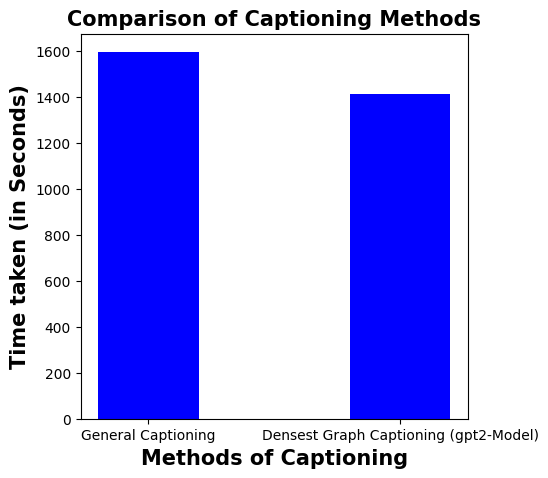

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
Methods = ['General Captioning','Densest Graph Captioning (gpt2-Model)']
Times = [end_time-start_time,gpt_end_time_captioning-gpt_start_time_captioning]
  
fig = plt.figure(figsize = (5, 5))
 
# creating the bar plot
plt.bar(Methods, Times, color ='blue',width=0.4)
 
plt.xlabel("Methods of Captioning",fontweight ='bold', fontsize = 15)
plt.ylabel("Time taken (in Seconds)",fontweight ='bold', fontsize = 15)
plt.title("Comparison of Captioning Methods",fontweight ='bold', fontsize = 15)
plt.show()

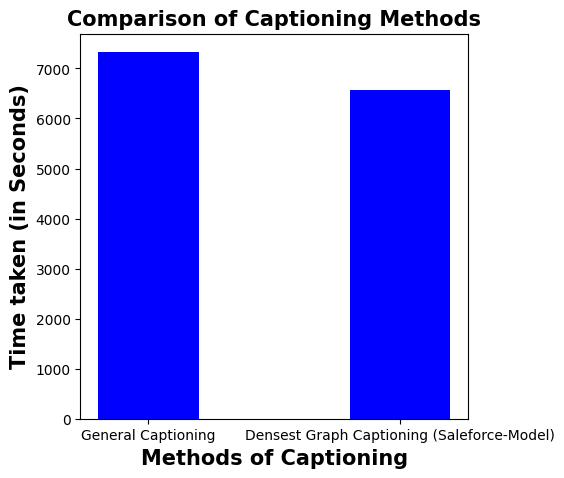

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
Methods = ['General Captioning','Densest Graph Captioning (Saleforce-Model)']
Times = [salesforce_end_time_normal-salesforce_start_time_normal,salesforce_end_time_captioning-salesforce_start_time_captioning]
  
fig = plt.figure(figsize = (5, 5))
 
# creating the bar plot
plt.bar(Methods, Times, color ='blue',width=0.4)
 
plt.xlabel("Methods of Captioning",fontweight ='bold', fontsize = 15)
plt.ylabel("Time taken (in Seconds)",fontweight ='bold', fontsize = 15)
plt.title("Comparison of Captioning Methods",fontweight ='bold', fontsize = 15)
plt.show()

In [ ]:
print(len(gpt_captions_normal))
print(len(gpt_captions_normal_densest))
print(len(salesforce_captions_normal_densest))

441
441
441


## Bleu Score

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
a = []
b = []
for i in range(len(gpt_captions_normal)):
  x = gpt_captions_normal[i][0]['generated_text']
  try:
    y = gpt_captions_normal_densest[i][0]['generated_text']
  except:
    y = gpt_captions_normal_densest[i]
  a.append(x)
  b.append(y)

a = a[start-1:end]
b = b[start-1:end]

In [ ]:
c = []
d = []
for i in range(len(gpt_captions_normal)):
  x = salesforce_captions_normal[i]
  try:
    y = salesforce_captions_normal_densest[i]
  except:
    y = salesforce_captions_normal_densest[i]
  c.append(x)
  d.append(y)

c = c[start-1:end]
d = d[start-1:end]

In [ ]:
## Individual Bleu Score
gpt_densest_bleu_scores=0
for i in range(len(a)):
  gpt_densest_bleu_scores+=sentence_bleu([a[i]],b[i],weights=(1,0,0,0))
print(gpt_densest_bleu_scores/(end-start))

0.5056390977443614


In [ ]:
## Individual Bleu Score
salesforce_densest_bleu_scores=0
for i in range(len(c)):
  salesforce_densest_bleu_scores+=sentence_bleu([c[i]],d[i],weights=(1,0,0,0))
print(salesforce_densest_bleu_scores/(end-start))

0.5462184873949583


## ROUGE score

In [ ]:
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from rouge import Rouge

rouge = Rouge()

gpt_densest_rouge_scores = rouge.get_scores(a,b,avg=True)

print(gpt_densest_rouge_scores)

{'rouge-1': {'r': 0.18023255813953498, 'p': 0.3042635658914729, 'f': 0.22532299275658924}, 'rouge-2': {'r': 0.00436046511627907, 'p': 0.009966777408637873, 'f': 0.006066733779399496}, 'rouge-l': {'r': 0.18023255813953498, 'p': 0.3042635658914729, 'f': 0.22532299275658924}}


In [ ]:
from rouge import Rouge

rouge = Rouge()

salesforce_densest_rouge_scores = rouge.get_scores(c,d,avg=True)

print(salesforce_densest_rouge_scores)

{'rouge-1': {'r': 0.48966408268733835, 'p': 0.8068710359408032, 'f': 0.609119023828044}, 'rouge-2': {'r': 0.20000000000000004, 'p': 0.34573643410852734, 'f': 0.25310077055151803}, 'rouge-l': {'r': 0.277777777777778, 'p': 0.45859760394644106, 'f': 0.3457822536749146}}


## Longest Common Subsequence

In [ ]:
!pip install pylcs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for pylcs: filename=pylcs-0.0.8-cp310-cp310-linux_x86_64.whl size=1125583 sha256=4cf6ce4b3d2ea3f3c8fd86c12e3f66a2b399815ad9f7b59916285ea6487de0d5
  Stored in directory: /root/.cache/pip/wheels/b1/e8/5e/6f59ae9659e08741bef7f18f130e81fa82c3d9726449d5bf20
Successfully built pylcs


In [ ]:
import pylcs

gpt_densest_lcs_score=0

for i in range(len(a)):
  gpt_densest_lcs_score+=pylcs.lcs_sequence_length(a[i], b[i])

print(gpt_densest_lcs_score/len(a))


26.372093023255815


In [ ]:
import pylcs

gpt_densest_lcs_score=0

for i in range(len(c)):
  gpt_densest_lcs_score+=pylcs.lcs_sequence_length(c[i], d[i])

print(gpt_densest_lcs_score/len(c))


48.04651162790697
